In [1]:
import swarms
import pread as pd
from numpy import linspace, logspace, pi, array
import matplotlib.pyplot as plt

In [2]:
"""Access times with data.ages in years
          radii with data.radii in meters
          luminosity with data.lumin in watts
First entry is the root directory.
Second entry is the subdirectory.
Third entry is the filename.
"""
def data_read(mass):
    data = pd.Pread('data', 'Z002', 'pltlum_M'+str(mass)+'Z002.csv') 
    return data

In [3]:
RHO=1500
M0 = 0.1 * 7.34767309e22; d_pl = 20 * 3.086e16; star_type = "M"
eta = 0.4; Nstr = 6.; Dt = 100.; Dmax = 150000.; R_pl = 6.9911e7

lamb = 1.65e-6
time = [1.5e7, 5e7, 1e8, 3e8]
M_jup = [20, 100, 318, 636]
a_plv = linspace(2 * 1.496e11, 80 * 1.496e11, 500)

In [4]:
def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

In [5]:
def find_star_flux(type_star, lamb):
    if type_star == "A":
        M_s = 2.1 * 1.989e30
        L_s = 20 * 3.828e26
    elif type_star == "G":
        M_s = 1 * 1.989e30
        L_s = 1 * 3.828e26
    elif type_star == "M":
        M_s = 0.21 * 1.989e30
        L_s = 0.0079 * 3.828e26

    return M_s, L_s

In [6]:
def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

C:\Users\loloynage\Documents\CE-Irregular-Satellites\src\swarms.py:270: RuntimeWarning: overflow encountered in exp
  b = 1/(exp(h*(c/lamb)/(k_B*T)) - 1)


<Figure size 432x288 with 0 Axes>

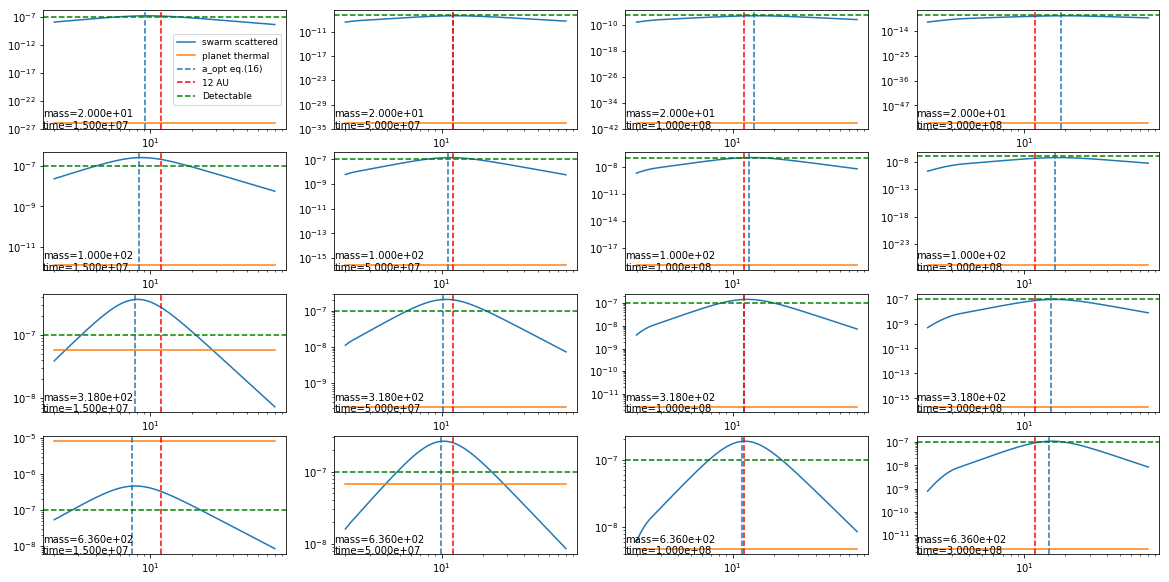

In [7]:
plt.figure(1)
fig, axes = plt.subplots(len(M_jup), len(time), subplot_kw=dict(), figsize=(20, 10))
M_s, L_s = find_star_flux(star_type, lamb)
for w in range(len(M_jup)):
    data = data_read(M_jup[w])
    for k in range(len(time)):    
        
        fth_list = []
        fs_list = []
        fth_plt_list = []
        for i in range(len(a_plv)):

            s = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_jup[w]*5.972e24, a_plv[i], R_pl, eta, Nstr,
                        d_pl, correction=True, alpha=1.2)

            s.updateSwarm(time[k])
            T_star = s.stellarTemp()
            B_nu_list = s.computeBmu(array([lamb]), T_star)
            F_star = Fstar(L_s, B_nu_list, T_star, d_pl)/1e-26

            f_vrel = 4/pi
            Qd = s.computeQd(s.Dc)
            part1 = (M_s/1.989e30)**0.33 * f_vrel**0.55
            part2 = (M_jup[w])**0.06 * Qd**0.15 * eta
            part3 = time[k] * (M0/5.972e24) / (RHO * (s.Dc/1000)) 

            a_opt = 50 * part1 / part2 * part3**0.24 
            
            
            s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_jup[w]*5.972e24,
                                    a_plv[i], R_pl, eta, Nstr, d_pl,
                                    rho=RHO, fQ=5, f_vrel=4/pi,
                                    correction=True, alpha=1.2)

            s2.updateSwarm(time[k])
            
            # Planet Emissions
            index = data.find_time_index(time[k])
            if (index > -1):
                T_plt = lum_to_temp(data.lumin[index], data.radii[index])
                B_nu_plt = s2.computeBmu(array([lamb]), T_plt)
                F_plt = Fstar(data.lumin[index], B_nu_plt, T_plt, d_pl)
                fth_plt_list.append(F_plt/1e-26)
            
            # Swarm Emissions
            F_th = s2.computeFth(array([lamb]), swarm=True)
            F_s = s2.computeFs(array([lamb]), 0.32, 0.08, swarm=True)

            fth_list.append(F_th[0]/1e-26)
            fs_list.append(F_s[0]/1e-26)

        contrast_ratio_apl_th = array(fth_list) / F_star
        contrast_ratio_apl_s = array(fs_list) / F_star
        contrast_ratio_apl_plt_th = array(fth_plt_list) / F_star

        axes[w, k].loglog(a_plv/1.496e11, contrast_ratio_apl_s, label="swarm scattered")
        axes[w, k].loglog(a_plv/1.496e11, contrast_ratio_apl_plt_th, label="planet thermal")
        axes[w, k].axvline(a_opt, ls='--',label="a_opt eq.(16)")
        axes[w, k].axvline(12, color='r', ls='--',label="12 AU")
        axes[w, k].axhline(1e-7, color='g', ls='--',label="Detectable")
        axes[w, k].text(0, 0, 'mass={0:.3e}'.format(M_jup[w])+'\n'+'time={0:.3e}'.format(time[k]), transform=axes[w, k].transAxes) 
        if w == 0 and k == 0:
            axes[w, k].legend(prop={'size': 9})
            #axes[w, k].xlabel("a_pl [au]")
            #axes[w, k].ylabel("F_swarm / F_star")
plt.show()